<h1>Inteligência Artificial Preditiva: Auto ML</h1>

<p>Este notebook tem como objetivo explorar 5 principais modelos de inteligência artificial preditiva: </p>
<ol>
    <h3>Regressão</h3>
<li>Regressão Linear</li>
    <h3>Classificação</h3>
<li>Naive Bayes</li>
<li>Decision Tree: Gini</li>
<li>Decision Tree: Entropia</li>
<li>K-Nearest Neighbors (KNN)</li>
</ol>

<p>Desses 5, usaremos a que melhor performou para a base de dados que você irá inserir!
</p>

#### CODEOWNERS:
- **Rafael Cruz** [GitHub](https://github.com/RafaelBarretoCruz)
- **Gabriel Martins** [GitHub](https://github.com/GabrielOliveiraGerminare1H)
- **Fellipe Meira** [GitHub](https://github.com/fellipemeiraGerminare)



<h1> Importando bibliotecas </h1>

In [404]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay, \
    precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

import yellowbrick.classifier as yb


pd.set_option('display.max_columns', None)


<h1> Carregando a base de dados </h1>

In [405]:
csv_nome = input("Digite o nome do arquivo CSV (incluindo a extensão .csv): ")

# Detecta o delimitador automaticamente
with open(csv_nome, "r", encoding="utf-8") as f:
    sniffer = csv.Sniffer()
    sample = f.read(2048)
    f.seek(0)
    delimiter_encontrado = sniffer.sniff(sample).delimiter

print(f"Delimitador detectado: '{delimiter_encontrado}'")

try:
    data = pd.read_csv(csv_nome, delimiter=delimiter_encontrado)
    print("Arquivo carregado!")
except FileNotFoundError:
    print("Arquivo não encontrado. Verifique o nome e o caminho do arquivo.")
except Exception as e:
    print(f"Ocorreu um erro ao carregar o arquivo: {e}")

Delimitador detectado: ','
Arquivo carregado!


<h1> Primeira visualização da base</h1>

In [406]:
display(data.head())

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


<h1> Definindo a coluna que será prevista (variável target)</h1>

In [407]:
coluna_target = input("Digite o nome da coluna que você deseja prever (variável target): ")
if coluna_target not in data.columns:
    raise ValueError(f"A coluna '{coluna_target}' não existe na base de dados.")
else:
    x = data.drop(columns=[coluna_target])
    y = data[coluna_target]

<h1> Pré-processamento dos dados </h1>

In [408]:
num_cols = x.select_dtypes(include=["int64", "float64"]).columns
cat_cols = x.select_dtypes(include=["object", "category"]).columns

# Codificar categóricas
for col in cat_cols:
    le = LabelEncoder()
    x[col] = le.fit_transform(x[col].astype(str))

# Normalizar apenas se houver numéricas
if len(num_cols) > 0:
    scaler = StandardScaler()
    x[num_cols] = scaler.fit_transform(x[num_cols])

<h1> Visualizando novamente a base de dados </h1>

In [409]:
display(x.head())

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud
0,-4.132243,3,-0.476063,12031,-0.260478,-0.266174,32431,-0.367111,-0.423197,0.0
1,-4.132243,3,-0.499179,34878,-0.313097,-0.315319,33746,-0.367111,-0.423197,0.0
2,-4.132243,4,-0.504058,15860,-0.320542,-0.322079,9437,-0.367111,-0.423197,0.0
3,-4.132243,1,-0.504058,93247,-0.320542,-0.322079,8393,-0.358285,-0.423197,0.0
4,-4.132243,3,-0.470763,54896,-0.305921,-0.311656,16923,-0.367111,-0.423197,0.0


<h1> Separação entre treino e teste </h1>

In [410]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.21, random_state=42
)

<h1> Detectando o tipo da variável target para seguirmos com o modelo</h1>

In [411]:
if y.dtype == "object" or len(np.unique(y)) < 30:
    problema = "classificacao"
else:
    problema = "regressao"

<h1> Definindo possíveis modelos </h1>

In [412]:
if problema == "classificacao":
    modelos = {
        "Decision Tree (Gini)": DecisionTreeClassifier(criterion="gini", random_state=42),
        "Decision Tree (Entropia)": DecisionTreeClassifier(criterion="entropy", random_state=42),
        "Naive Bayes": GaussianNB(),
        "KNN": KNeighborsClassifier(),
    }
else:
    modelos = {
        "Regressão Linear": LinearRegression(),
    }


<h1> Treinando e avaliando os modelos </h1>

In [413]:
resultados = {}

for nome, modelo in modelos.items():
    modelo.fit(x_train, y_train)
    y_pred = modelo.predict(x_test)

    if problema == "classificacao":
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="weighted")
        precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        recall = recall_score(y_test,y_pred, average="weighted", zero_division=0)
        resultados[nome] = {"Accuracy": acc, "F1-Score": f1, "Precision": precision, "Recall": recall}
    else:
        mse = mean_squared_error(y_test, y_pred)
        resultados[nome] = {"MSE": mse}

<h1> Resultados dos modelos </h1>

In [414]:
df_resultados = pd.DataFrame(resultados).T
display(df_resultados)

# Identificar melhor modelo
if problema == "classificacao":
    melhor = df_resultados["Accuracy"].idxmax()

else:
    melhor = df_resultados["MSE"].idxmin()


,Accuracy,F1-Score,Precision,Recall
Decision Tree (Gini),0.999250,0.999250,0.999250,0.999250
Decision Tree (Entropia),0.999391,0.999384,0.999377,0.999391
Naive Bayes,0.990253,0.994086,0.997983,0.990253
KNN,0.998969,0.998454,0.997939,0.998969


<h1> Modelo campeão </h1>

In [415]:
print(f"O melhor modelo é: {melhor}")

O melhor modelo é: Decision Tree (Entropia)


<h1> Mais visualizações do modelo campeão</h1>

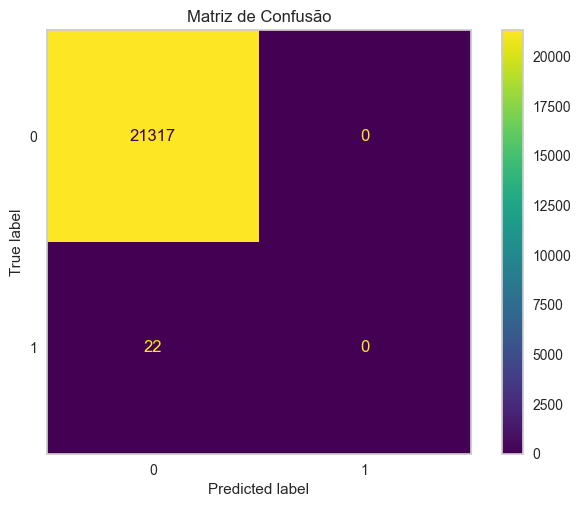

C:\Users\rafaelcruz-ieg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


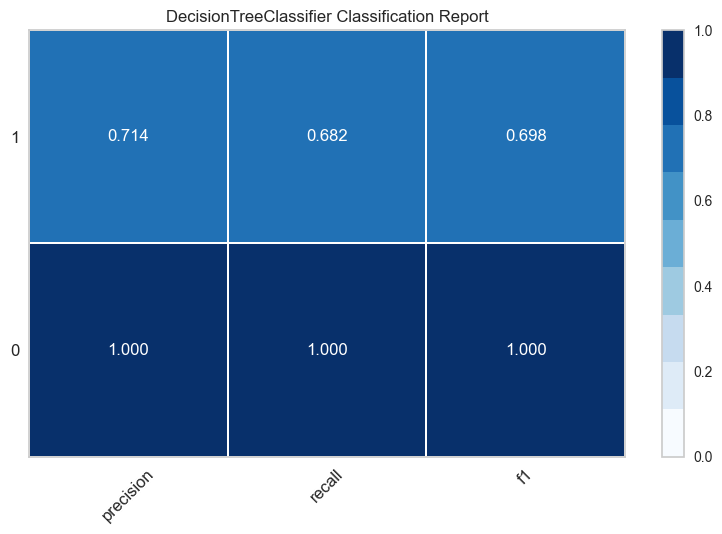

C:\Users\rafaelcruz-ieg\AppData\Local\Temp\ipykernel_4936\4139640212.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_resultados.index, y='Accuracy', data=df_resultados, palette="viridis")


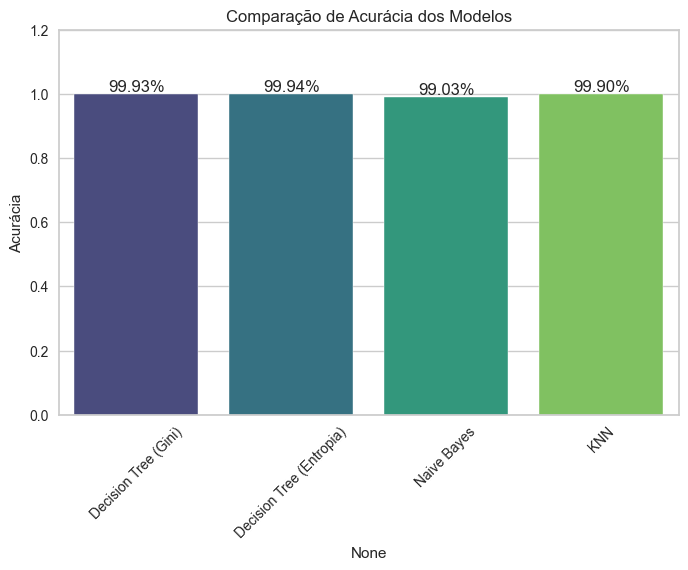

In [416]:
if problema == "classificacao":
    matriz = confusion_matrix(y_test, y_pred, labels=modelos[melhor].classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=modelos[melhor].classes_)
    disp.plot(cmap=plt.cm.viridis)
    plt.grid(False)
    plt.title('Matriz de Confusão')
    plt.show()


    visualizer = yb.ClassificationReport(
                                        modelos[melhor],
                                        classes=modelos[melhor].classes_,
                                        cmap= "Blues")

    visualizer.fit(x_train, y_train)

    visualizer.score(x_test, y_test)

    visualizer.show()

    plt.figure(figsize=(8,5))
    ax = sns.barplot(x=df_resultados.index, y='Accuracy', data=df_resultados, palette="viridis")
    plt.ylim(0, 1.2)
    plt.title("Comparação de Acurácia dos Modelos")
    plt.ylabel("Acurácia")
    plt.xticks(rotation=45)
    for container in ax.containers:
        ax.bar_label(container, labels=[f'{v.get_height()*100:.2f}%' for v in container])
    plt.show()


    # else:
# Fazer as visualizações para regressão. (Não aprendi_)